In [1]:
pip install --upgrade numpy==1.23.5 scipy nltk googletrans==4.0.0-rc1 textblob matplotlib torch transformers


  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/17/f2/f01ea29c8eff8e749d96525a17c2d3ec02656cec9a80c20fb3e74dba4b04/transformers-4.45.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/44.4 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.4 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.4 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.4 kB 108.9 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/44.4 kB 145.2 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.4 kB 163.4 kB/s eta 0:00:01
     -------------------------------------- 44.4/44.4 kB 145.3 kB/s eta 0:00:00
  Obtaining dependency information for huggingface-hub<1.0,>=0.23.2 from https://files.pythonhosted.org/packages/5f/f1/15dc793cb109a801346f910a6b350530f2a763a6e83b221725a0bcc1e297

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.4.0 requires fsspec==2023.4.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
from googletrans import Translator
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.special import softmax

c:\Users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load the dataset
df = pd.read_csv('Japan Public Sentiment 2-10-2024.csv')

In [19]:

# Initialize translator
translator = Translator()

# Function to translate and clean data
def translate_and_clean(text):
    try:
        translated = translator.translate(text, src='ja', dest='en').text
        # Add any additional cleaning steps here if needed
        return translated
    except:
        return ''

# Translate and clean data
df['translated_text'] = df['Post Body'].apply(translate_and_clean)


In [20]:
# Preprocess the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['translated_text'].apply(preprocess_text)

# Convert 'Likes' to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        else:
            return float(value.replace(',', ''))
    return float(value)

df['Likes_numeric'] = df['Likes'].apply(convert_to_numeric)


In [21]:

# TextBlob analysis by like count
df['textblob_sentiment'] = df['translated_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [22]:

# TextBlob sentiment analysis
def textblob_sentiment_category(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['textblob_sentiment_category'] = df['textblob_sentiment'].apply(textblob_sentiment_category)


In [23]:

# BERT sentiment analysis
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def bert_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = softmax(outputs.logits.numpy(), axis=1)
    return scores.argmax() + 1

df['bert_sentiment'] = df['translated_text'].apply(bert_sentiment)


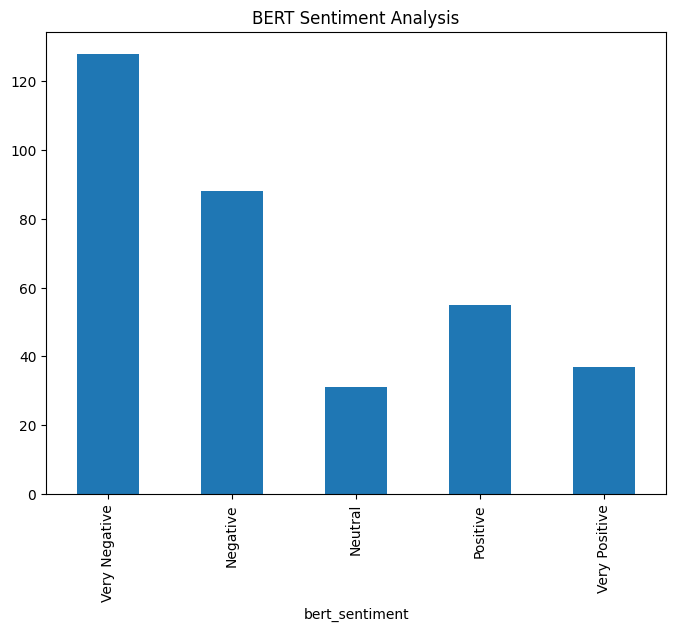

In [24]:

# Visualization for BERT sentiment analysis
plt.figure(figsize=(8, 6))
df['bert_sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('BERT Sentiment Analysis')
plt.xticks(range(5), ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])
plt.show()


Agreement between TextBlob and BERT: 23.89%


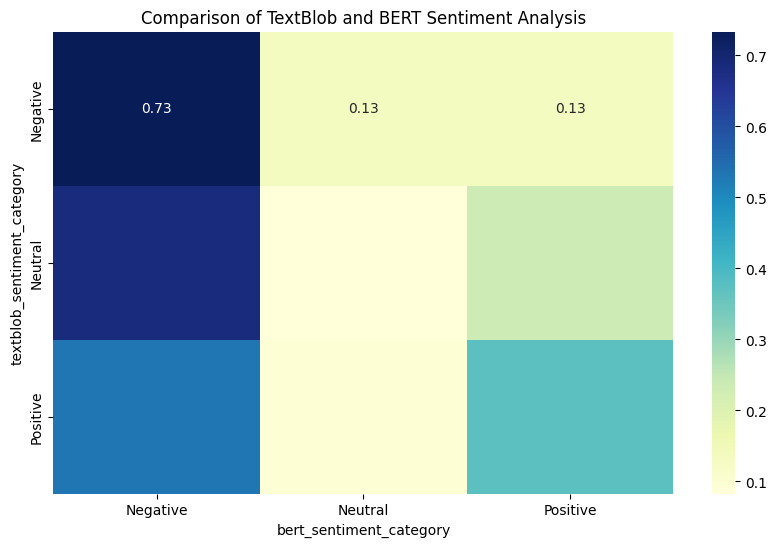

In [25]:

# Compare TextBlob and BERT results
df['bert_sentiment_category'] = df['bert_sentiment'].map({1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'})
agreement = (df['textblob_sentiment_category'] == df['bert_sentiment_category']).mean()
print(f"Agreement between TextBlob and BERT: {agreement:.2%}")

# Visualization for comparison
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['textblob_sentiment_category'], df['bert_sentiment_category'], normalize='index'), annot=True, cmap='YlGnBu')
plt.title('Comparison of TextBlob and BERT Sentiment Analysis')
plt.show()


In [26]:
# Save the results to a CSV file
df.to_csv('Japan_sentiment_analysis_results.csv', index=False)